In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Fitting of neuron network for classification of images

We will work with CIFAR dataset which includes images 32x32 with 3 channels, which divide by 10 classes. In train set has 50000 images.

Classes of CIFAR:
1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
9. Truck

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Three numbers because we have colorized images (with 3 channels) and this is 
# mean and std for each channel (in first tuple mean, in second - std)

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                       download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                              shuffle=True, num_workers=1)

valset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size=16,
                                             shuffle=True, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# One iteration in dataloader (i.e., one batch with 16 elements)

def matplotlib_imshow(img, one_channel=False): # function of plotting of images
    if one_channel:
        img=img.mean(dim=0)
    img = img/2 + 0.5        # unnormalize
    npimg = img.numpy()
    
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))

# creating of grid of images
img_grid = torchvision.utils.make_grid(images)

# showing images
matplotlib_imshow(img_grid, one_channel=False)

In [4]:
NUM_EPOCH = 25

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_history(train_history, val_history, title='Loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history)/len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('Train steps')
    
    plt.legend(loc='best')
    plt.grid()
    
    plt.show()

As baseline we will taken a convolutional network, consists by 1 VGG block.

VGG block itself consists by two subsequent convolutional layers with ReLU nonlinearity beween them and max-pooling then. VGG uses small filters of size 3x3 and padding.

### The baseline architecture is:

1) VGG block with 16 channels:

* convolutional layer with 16 output channels, kernel of size 3x3 and ReLU nonlinearity
* convolutional layer with 16 output channels, kernel of size 5x5 and ReLU nonlinearity
* max pooling with kernel of size 2x2 and step size 2
    
2) Fully connected layer with 128 outputs

3) Fully connected layer with 10 outputs and softmax

In [6]:
# Class of our baseline model

class ModelBaseline(nn.Module):
    def __init__(self):
        super(ModelBaseline, self).__init__()
        self.vgg_block = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), # (input channels, output channels, kernel size), for cernel size 3x3 we need padding in 1 cell
            nn.ReLU(),
            nn.Conv2d(16, 16, 5, padding=2), # (input channels, output channels, kernel size), for cernel size 5x5 we need padding in 2 cells
            nn.ReLU(),
            nn.MaxPool2d(2) # here size of image is 16x16x16 because of padding is saving sizes of images when convolution
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*16*16, 128),
            nn.Linear(128, 10) # we dont use softmax here because of entropy loss already use softmax for values
        )
            
    def forward(self, x):
        x = self.vgg_block(x)
        x = self.fc_layers(x)
        return x

In [7]:
model_baseline = ModelBaseline()

### Cycle of fitting:

In [7]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader, n_epochs):
    '''
    model - neuron network with custom architecture
    criterion - loss function
    train_dataloader - dataloader of train dataset
    test_dataloaser - dataloader of test dataset
    
    '''
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    
    for epoch in range(n_epochs):
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        
        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device) # sending the imgs and labels to device (cpu or gpu)
            
            optimizer.zero_grad()
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            
            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat((train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))
        
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat((
                                              train_epoch_true_hits,
                                              (pred_classes == labels.cpu()).sum().unsqueeze(0)
                                              ))
            train_acc_log.append((pred_classes == labels.cpu()).sum() / labels.cpu().shape[0])
        
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(train_dataloader, desc=f"Validating, epoch {epoch}", leave=False): # tqdm needed for paining of progress bar
                imgs, labels = imgs.to(device), labels.to(device)
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
                
                
                pred_classes = torch.argmax(pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat((
                                              val_epoch_true_hits,
                                              (pred_classes == labels.cpu()).sum().unsqueeze(0)
                                              ))

            val_loss_log.append(val_epoch_loss.mean())
            val_acc_log.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        
            clear_output()
            plot_history(train_loss_log, val_loss_log, 'Loss')    # this func paints graphs 
            plot_history(train_acc_log, val_acc_log, 'Accuracy')
        
        
            print('Train loss:', train_epoch_loss.mean().item())
            print('Train acc:', (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item())
            print('Val loss:', val_epoch_loss.mean().item())
            print('Val acc:', (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item(), "\n")

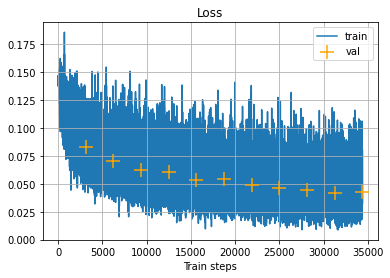

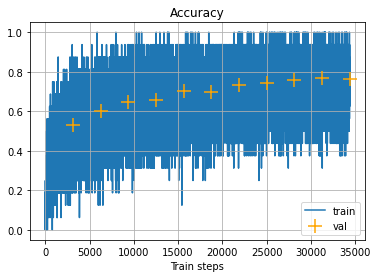

Train loss: 0.046080850064754486
Train acc: 0.7420600056648254
Val loss: 0.04243960976600647
Val acc: 0.7641199827194214 



Training, epoch 11:   0%|          | 0/3125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader, NUM_EPOCH)

## Data augmentations

In [9]:
import PIL

transform = transforms.Compose(
    [transforms.ColorJitter(hue=.05, saturation=.05),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(20),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                       download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                              shuffle=True, num_workers=1)

valset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size=16,
                                             shuffle=True, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


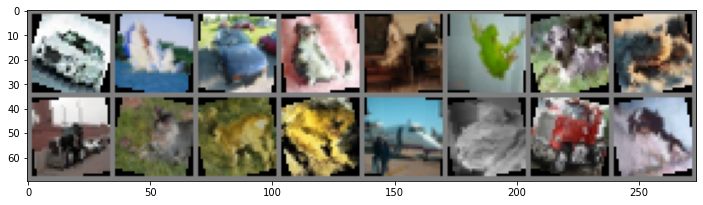

In [10]:
# showing augmented images

images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))

# creating of grid of images
img_grid = torchvision.utils.make_grid(images)

# showing images
matplotlib_imshow(img_grid, one_channel=False)

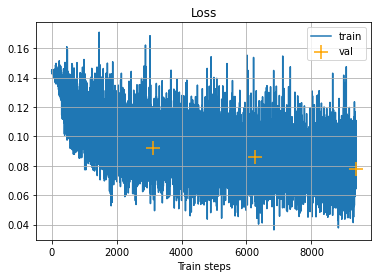

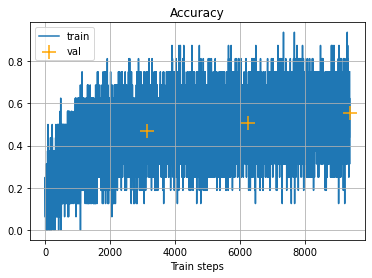

Train loss: 0.0823584571480751
Train acc: 0.5327799916267395
Val loss: 0.07785267382860184
Val acc: 0.5560200214385986 



Training, epoch 3:   0%|          | 0/3125 [00:00<?, ?it/s]

In [ ]:
model_baseline = ModelBaseline()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader, NUM_EPOCH)

## Dropout and Batch normalization using

Let's use dropout with some parameter and batch normalization in our convolution neural network.

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Three numbers because we have colorized images (with 3 channels) and this is 
# mean and std for each channel (in first tuple mean, in second - std)

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                       download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                              shuffle=True, num_workers=1)

valset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size=16,
                                             shuffle=True, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


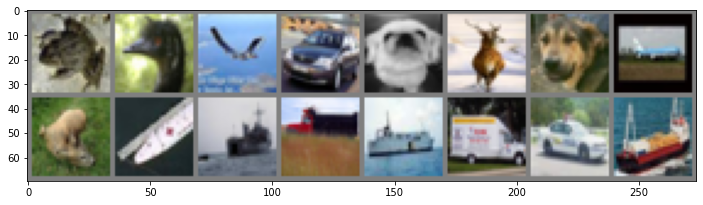

In [9]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))

# creating of grid of images
img_grid = torchvision.utils.make_grid(images)

# showing images
matplotlib_imshow(img_grid, one_channel=False)

In [13]:
# Class of our baseline model

class ModelBatchnormAndDropout(nn.Module):
    def __init__(self):
        super(ModelBatchnormAndDropout, self).__init__()
        self.vgg_block1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), # (input channels, output channels, kernel size), for cernel size 3x3 we need padding in 1 cell
            nn.BatchNorm2d(16), # Batch normalisation
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), # (input channels, output channels, kernel size), for cernel size 3x3 we need padding in 1 cells
            nn.BatchNorm2d(16), # Batch normalisation
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # here size of image is 16x16x16 because of padding is saving sizes of images when convolution
            nn.Dropout(0.2) # Dropout with parameter 0.2
        )
        
        self.vgg_block2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), # (input channels, output channels, kernel size), for cernel size 3x3 we need padding in 1 cell
            nn.BatchNorm2d(32), # Batch normalisation
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), # (input channels, output channels, kernel size), for cernel size 3x3 we need padding in 1 cells
            nn.BatchNorm2d(32), # Batch normalisation
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # here size of image is 16x16x16 because of padding is saving sizes of images when convolution
            nn.Dropout(0.2) # Dropout with parameter 0.2
        )
        
        self.vgg_block3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), # (input channels, output channels, kernel size), for cernel size 3x3 we need padding in 1 cell
            nn.BatchNorm2d(64), # Batch normalisation
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), # (input channels, output channels, kernel size), for cernel size 3x3 we need padding in 1 cells
            nn.BatchNorm2d(64), # Batch normalisation
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # here size of image is 16x16x16 because of padding is saving sizes of images when convolution
            nn.Dropout(0.2) # Dropout with parameter 0.2
        )
        
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
            
    def forward(self, x):
        x = self.vgg_block1(x)
        x = self.vgg_block2(x)
        x = self.vgg_block3(x)
        x = self.fc_layers(x)
        return x

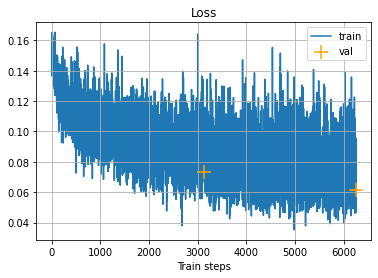

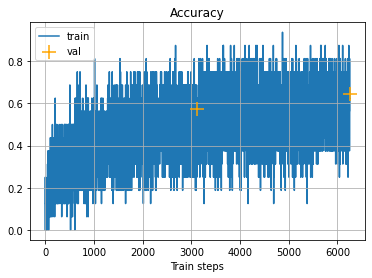

Train loss: 0.07911119610071182
Train acc: 0.5511599779129028
Val loss: 0.06122764199972153
Val acc: 0.6457399725914001 



Training, epoch 2:   0%|          | 0/3125 [00:00<?, ?it/s]

In [ ]:
model_batchnorm_dropout = ModelBatchnormAndDropout()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_batchnorm_dropout.parameters(), lr=0.001, momentum=0.9)

train(model_batchnorm_dropout, criterion, optimizer, train_dataloader, val_dataloader, NUM_EPOCH)